## This Notebook Uses The Amazon Reviews Dataset And Predict Whether The Review Is Positive Or Negative Using KNeighbors Classifier(KNN)

Source of data = https://www.kaggle.com/snap/amazon-fine-food-reviews 
Thanks To AAIC Team for Teaching me Applied Machine Learning

In [3]:

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
!ls "/content/drive/My Drive/"

'Colab Notebooks'  'Colab Uploads'   Reviews.csv   Untitled0.ipynb


In [2]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix,auc
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from tqdm import tqdm
import scipy.sparse as mat
import warnings
warnings.filterwarnings("ignore")
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack

In [82]:
data = pd.read_csv("Reviews.csv")

In [83]:
data = data[data.Score!=3]

In [84]:
data.shape

(525814, 10)

In [85]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [86]:
data['ProductId'].nunique()

72005

In [87]:
data['UserId'].nunique()

243414

In [88]:
# To predict the polarity of review, we have to use the scores provided in the data and hence we will convert the score
# into binary values
def Classifier(x):
    if x<3:
        return 0
    return 1
data['Score']=data['Score'].map(Classifier)

In [89]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [90]:
final_data = data.drop_duplicates(subset = ['UserId','ProfileName','Time','Text'])

In [91]:
final_data = final_data.dropna()

In [116]:
#Using Only 1000 Points due to computuional power constraints
final_data = final_data[:1000]

In [117]:
final_data.shape

(1000, 10)

## Preprocessing the text

All the credits to AAIC team for wonderful course.
1. Begin by removing the html tags, we will use beautiful soup for this.
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Wordnet lemmatizer as it is better than snowball stemmer

In [118]:
# importing the libraries needed
import re
import nltk
import string
from bs4 import BeautifulSoup

In [119]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to C:\Users\Akash
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Akash
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [120]:
stopword = nltk.corpus.stopwords.words('english')


In [121]:
lemm = nltk.stem.wordnet.WordNetLemmatizer()
stemm = nltk.stem.SnowballStemmer('english')

In [122]:
#this is how the lemmatizer works
lemm.lemmatize('communities')

'community'

In [123]:
stemm.stem('communities')

'communiti'

In [124]:
stopword = set(stopword)

We will use lemmatizer as it makes use of dictionary and is good for our problem

#### Pre-Processing the data

In [125]:
def cleaner(phrase):
    # decontraction
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)  # r means raw string
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    #removing words with numbers and special characters
    phrase = re.sub(r"\S*\d\S","", phrase).strip()
    phrase = re.sub(r"[^A-Za-z0-9]+"," ",phrase)
    return phrase

In [126]:
from tqdm import tqdm
cleaned_text = []
words = []
for sent in tqdm(final_data['Text'].values):
    sent = BeautifulSoup(sent,'lxml').get_text()
    sent = cleaner(sent)
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopword)
    sent = ' '.join(lemm.lemmatize(e) for e in sent.split())
    cleaned_text.append(sent)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1078.51it/s]


In [127]:
len(cleaned_text)

1000

1. All the review text has been preprocessed. Now we will transform each review text into numerical vector. 
2. There are 4 major techniques.
3. Before we do that we will split our data into train, cross-validate and test data.


###### Splitting the data set

In [128]:
from sklearn.model_selection import train_test_split as splitter
xtr,xtest,ytr,ytest = splitter(cleaned_text,final_data['Score'],test_size = 0.2)


In [129]:
xtr_kd,xtest_kd,ytr_kd,ytest_kd = splitter(cleaned_text[:20000],final_data['Score'][:20000],test_size = 0.2)

#### Two Functions That We Will Use

In [130]:
def finding_right_k_model(xtrain,ytrain,xtestdata,ytestdata,algorithm='brute'):
    neigh = KNeighborsClassifier(algorithm=algorithm)
    K  = [1,10,30,50]
    parameters = {'n_neighbors':K}
    
    #doing the 3-fold cross validation using grid search to find the right k
    clf = GridSearchCV(neigh,parameters, cv = 3, scoring='roc_auc')
    clf.fit(xtrain,ytrain)
    #calculating auc-scores
    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    #plotting the auc-scores
    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    
    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("AUC SCORE PLOTS")
    plt.show()    


    

In [131]:
def final_model(xtrain,ytrain,xtestdata,ytestdata,best_k,algorithm = 'brute'):
    # Training the model with the right parameter

    neigh = KNeighborsClassifier(n_neighbors=best_k,algorithm = algorithm)
    neigh.fit(xtrain, ytrain)
    
    #plotting the roc_curve

    train_fpr, train_tpr, thresholds = roc_curve(ytrain, neigh.predict_proba(xtrain)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(ytestdata, neigh.predict_proba(xtestdata)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC-Curve")
    plt.show()

    print("="*100)
    print("Area Under Curve For Test Data is {}".format(auc(test_fpr, test_tpr)))
    
    #plotting the confusion matrix for testdata
    
    test_cm = confusion_matrix(ytestdata, neigh.predict(xtestdata))
    class_label = ["negative", "positive"]
    plt.subplot(1,1,1)
    df_test_cm = pd.DataFrame(test_cm, index = class_label, columns = class_label)
    sns.heatmap(df_test_cm, annot = True, fmt = "d",center =None)
    plt.title("Confusion Matrix For Testing data")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.show()

### Text Featurization

#### BAG OF WORDS

In [132]:
#Using Bag of words
import sklearn.feature_extraction.text as textfeat
bow = textfeat.CountVectorizer()
xtr_bow = bow.fit_transform(xtr)
xtest_bow = bow.transform(xtest)

#we did not fit xtest and xcv because that will cause shape mismatch, when we fit the model

In [133]:
xtr_bow.shape

(800, 4749)

In [134]:
xtest_bow.shape

(200, 4749)

#### applying brute knn

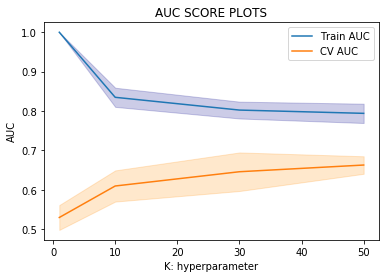

In [135]:
finding_right_k_model(xtr_bow,ytr,xtest_bow,ytest,algorithm = 'brute')

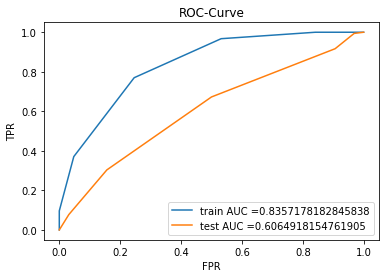

Area Under Curve For Test Data is 0.6064918154761905


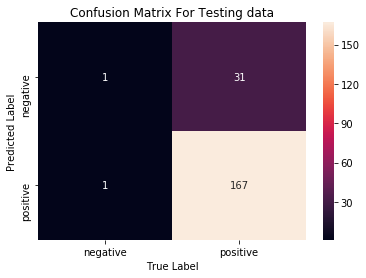

In [136]:
# As we can see that k=10 is the right k for us in bow
final_model(xtr_bow,ytr,xtest_bow,ytest,best_k=10)

#### applying kd tree

In [137]:
import sklearn.feature_extraction.text as textfeat
bow = textfeat.CountVectorizer(min_df =10,max_df =500)
xtr_nbow = bow.fit_transform(xtr_kd)
xtest_nbow = bow.transform(xtest_kd)

#converting sparse into dense matrix for kd-tree
xtr_nbow1 = mat.csr_matrix.toarray(xtr_nbow)
xtest_nbow1 = mat.csr_matrix.toarray(xtest_nbow)

#we did not fit xtest and xcv because that will cause shape mismatch, when we fit the model

In [138]:
xtr_nbow.shape # dimensions increases too much

(800, 521)

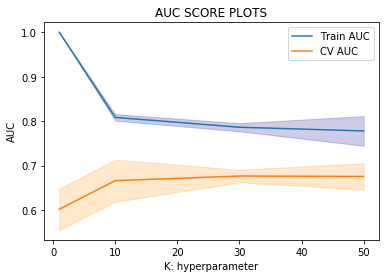

In [139]:
finding_right_k_model(xtr_nbow1,ytr_kd,xtest_nbow1,ytest_kd,algorithm = 'kd_tree')

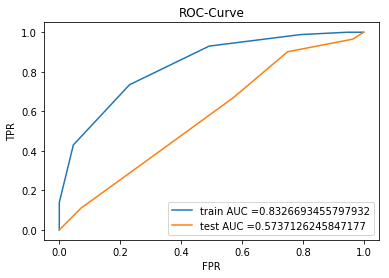

Area Under Curve For Test Data is 0.5737126245847177


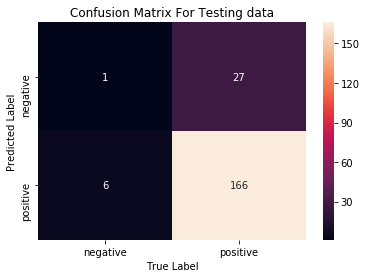

In [140]:
# As we can see that k=3 is the right k for us in bow
final_model(xtr_nbow1,ytr_kd,xtest_nbow1,ytest_kd,best_k=10,algorithm = 'kd_tree')

### Term Frequency Inverse Document Frequency

In [141]:
tfidf = textfeat.TfidfVectorizer(ngram_range=(1,2),min_df=10)
xtr_tf = tfidf.fit_transform(xtr)
xtest_tf = tfidf.transform(xtest)


In [142]:
xtest_tf.shape

(200, 572)

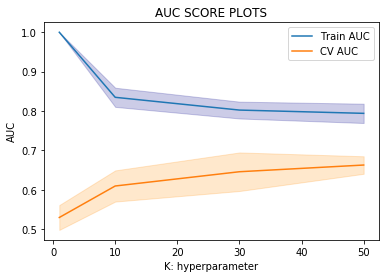

In [143]:
finding_right_k_model(xtr_bow,ytr,xtest_bow,ytest,algorithm = 'brute')

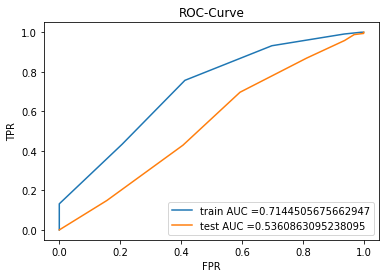

Area Under Curve For Test Data is 0.5360863095238095


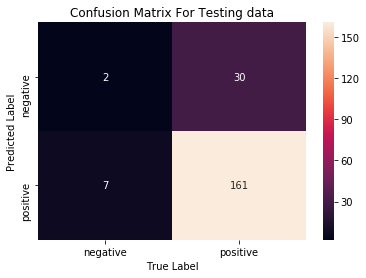

In [144]:
final_model(xtr_nbow,ytr,xtest_nbow,ytest,best_k=10)

#### implementing kd-tree

In [145]:
tfidf = textfeat.TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features = 500)
xtr_tf1 = tfidf.fit_transform(xtr_kd)
xtest_tf1 = tfidf.transform(xtest_kd)
#sparse to dense matrix
xtr_tf2 = mat.csr_matrix.toarray(xtr_tf1)
xtest_tf2 = mat.csr_matrix.toarray(xtest_tf1)

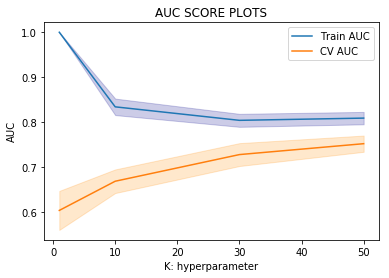

In [146]:
finding_right_k_model(xtr_tf2,ytr_kd,xtest_tf2,ytest_kd,algorithm = 'kd_tree')

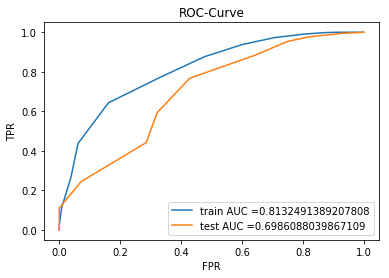

Area Under Curve For Test Data is 0.6986088039867109


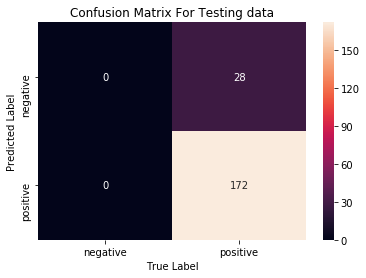

In [147]:
final_model(xtr_tf2,ytr_kd,xtest_tf2,ytest_kd,best_k=30,algorithm = 'kd_tree')

#### WORD2VEC

In [148]:
from gensim.models import Word2Vec, KeyedVectors

I created my own w2v model using only 80000 datapoints and got terrible accuracy. So I thought why not use all of the data to create word2vec model.

In [149]:
w2v_data = cleaned_text

In [150]:
type(w2v_data)

list

In [151]:
word_2_vec = Word2Vec(w2v_data,size= 40,min_count=4,workers=4)

### Average w2v

Now I have used data of 8000 cleaned reviews as I have done before with Other Text featurizers.

In [152]:
text_vec = []
for sentence in tqdm(cleaned_text):
    word_vec = np.zeros(40)
    cnt_words = 0
    for wor in sentence:
        if wor in word_2_vec:
            wor_vec = word_2_vec.wv[wor]
            word_vec = word_vec+wor_vec
            cnt_words += 1
    if cnt_words != 0:
        sen_vec = word_vec/cnt_words
    text_vec.append(sen_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 551.57it/s]


I was applying average w2v on train, test,cv data separately. Then my model was not recognizing negative datasets. So I searched google and found this nice https://www.kaggle.com/jinalsalvi/amazon-food-review-prediction-with-knn/notebook notebook, And saw the approach i have used now.

In [153]:
text_vec[1]

array([-0.00983145, -0.02498971, -0.10435098, -0.07521891, -0.11780162,
       -0.18123681, -0.12815796, -0.29077966,  0.2649439 ,  0.33073968,
       -0.13879456, -0.10884321, -0.31126478,  0.02633285,  0.0796529 ,
        0.0182172 , -0.16857687, -0.25127619, -0.04862012,  0.31345776,
       -0.00661095,  0.01362999, -0.17115323, -0.02678981,  0.03315577,
        0.13424965,  0.11181948,  0.29993445,  0.0774107 ,  0.04433676,
        0.02102971,  0.18911035,  0.31581398,  0.13353509, -0.24788642,
        0.10318062,  0.05435375, -0.13791335,  0.00985572, -0.17241328])

In [154]:
len(text_vec)

1000

In [155]:
#splitting the data into train,test
xtr_vec = text_vec[:len(xtr)]

xtest_vec = text_vec[len(xtr):]

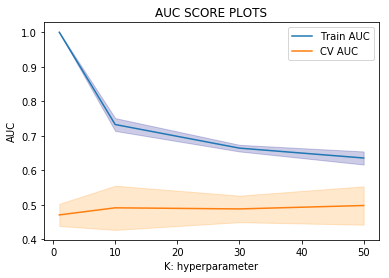

In [156]:
finding_right_k_model(xtr_vec,ytr,xtest_vec,ytest,algorithm = 'brute')

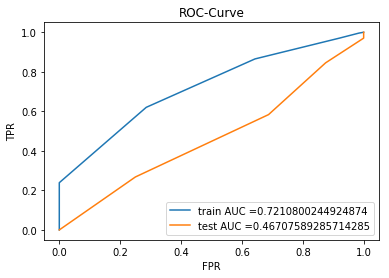

Area Under Curve For Test Data is 0.46707589285714285


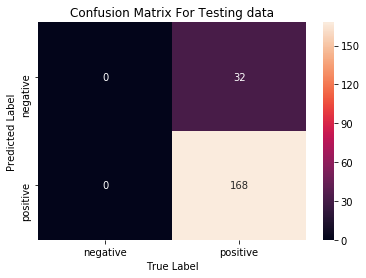

In [157]:
final_model(xtr_vec,ytr,xtest_vec,ytest,best_k=10)

AUC Score is very bad. Reason might be improper w2v.

#### kd-tree

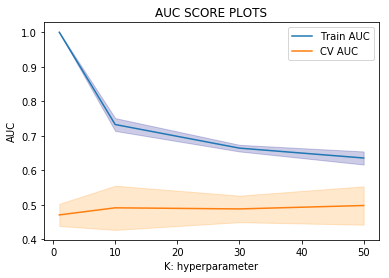

In [158]:
finding_right_k_model(xtr_vec,ytr,xtest_vec,ytest,algorithm = 'kd_tree') # wrod vectors are already dense

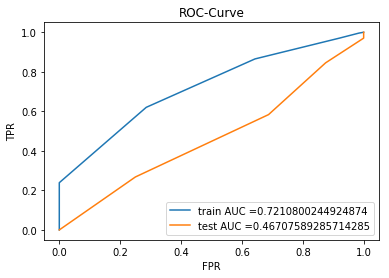

Area Under Curve For Test Data is 0.46707589285714285


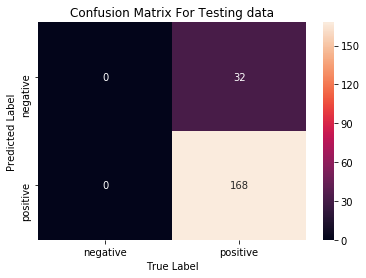

In [159]:
final_model(xtr_vec,ytr,xtest_vec,ytest,best_k = 10,algorithm ='kd_tree')

#### TFIDF-W2V

In [160]:
model = textfeat.TfidfVectorizer()
tf_idf_matrix = model.fit_transform(cleaned_text)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [161]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(cleaned_text): # for each review/sentence 
    sent_vec = np.zeros(40) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in word_2_vec and word in tfidf_feat:
            vec = word_2_vec.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.29it/s]


In [162]:
text_tfidf_vec = tfidf_sent_vectors

In [163]:
xtr_tfidf_vec = text_tfidf_vec[:len(xtr)]
xtest_tfidf_vec = text_tfidf_vec[len(xtr):]

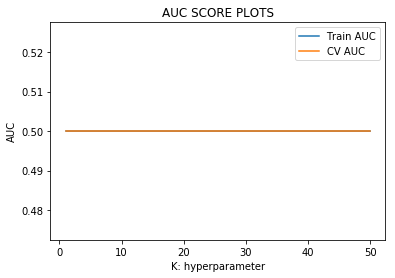

In [164]:
finding_right_k_model(xtr_tfidf_vec,ytr,xtest_tfidf_vec,ytest,algorithm = 'brute')

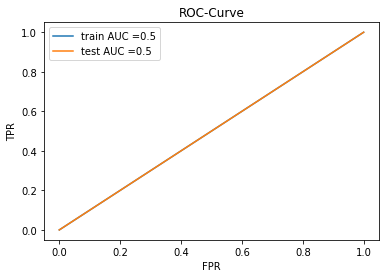

Area Under Curve For Test Data is 0.5


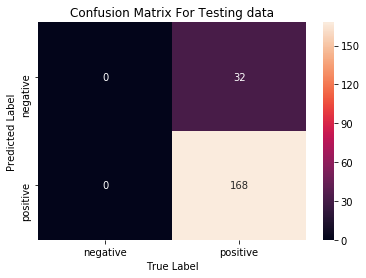

In [165]:
final_model(xtr_tfidf_vec,ytr,xtest_tfidf_vec,ytest,best_k=20)

#### kd tree

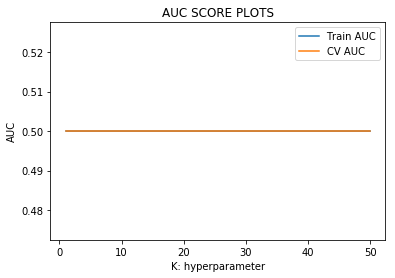

In [166]:
finding_right_k_model(xtr_tfidf_vec,ytr,xtest_tfidf_vec,ytest,algorithm = 'kd_tree')  # word vectors are already dense

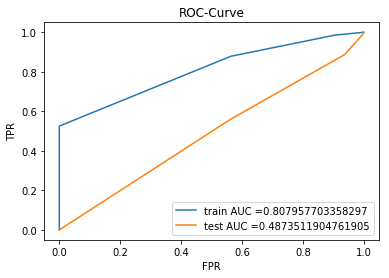

Area Under Curve For Test Data is 0.4873511904761905


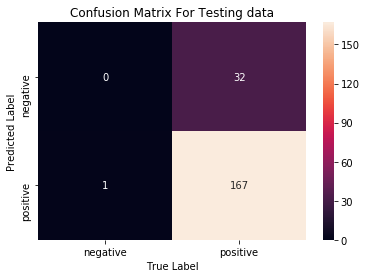

In [167]:
final_model(xtr_vec,ytr,xtest_vec,ytest,best_k=5,algorithm = 'kd_tree')

### Conclusion

In [168]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "Auc-score"]

x.add_row(["Bow", "Brute", 5, .71])
x.add_row(["Bow", "kd tree", 7, .63])
x.add_row(["tfidf", "Brute", 5, 0.65])
x.add_row(["tfidf", "kd-tree", 7, 0.79])
x.add_row(["avg-w2v", "brute", 3, 0.47])
x.add_row(["avg-w2v", "kd-tree", 3, 0.47])
x.add_row(["tfidf-w2v", "brute", 20, 0.5])
x.add_row(["tfidf-w2v", "kd-tree", 3, 0.47])

print(x)

+------------+---------+----------------+-----------+
| Vectorizer |  Model  | Hyperparameter | Auc-score |
+------------+---------+----------------+-----------+
|    Bow     |  Brute  |       5        |    0.71   |
|    Bow     | kd tree |       7        |    0.63   |
|   tfidf    |  Brute  |       5        |    0.65   |
|   tfidf    | kd-tree |       7        |    0.79   |
|  avg-w2v   |  brute  |       3        |    0.47   |
|  avg-w2v   | kd-tree |       3        |    0.47   |
| tfidf-w2v  |  brute  |       20       |    0.5    |
| tfidf-w2v  | kd-tree |       3        |    0.47   |
+------------+---------+----------------+-----------+


Above Scores were achieved with 5k datapoints. Which I had to change later due to some issue to 1000 data points

1. All the w2v models are not performing well, reason may be due to small training dataset for word2vec model.
2. tfidf-kdtree is the best performing model with about 80% accuracy on test data.(Generalization error is 20%)